In [31]:
#! pip install pandas-profiling
#! pip install funpymodeling
#! pip install reverse_geocoder

In [32]:
from datetime import timedelta
import pandas as pd
from pandas_profiling import ProfileReport
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import reverse_geocoder as rg
%matplotlib inline

In [3]:
%%time
#raw_data = pd.read_csv('./data/complete.csv')
scrubbed_data = pd.read_csv('../raw_data/scrubbed.csv', low_memory=False)

CPU times: user 263 ms, sys: 30.6 ms, total: 293 ms
Wall time: 288 ms


In [4]:
scrubbed_data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
#profile = ProfileReport(scrubbed_data, title="Pandas Profiling Report")

In [6]:
df = scrubbed_data.copy()

In [7]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,datetime,0,0.000000,0,0.0,69586,object
1,city,0,0.000000,0,0.0,19900,object
2,state,5797,0.072163,0,0.0,67,object
3,country,9670,0.120375,0,0.0,5,object
4,shape,1932,0.024050,0,0.0,29,object
5,duration (seconds),0,0.000000,0,0.0,537,object
6,duration (hours/min),0,0.000000,0,0.0,8349,object
7,comments,15,0.000187,0,0.0,79997,object
8,date posted,0,0.000000,0,0.0,317,object
9,latitude,0,0.000000,0,0.0,18445,object


In [8]:
df[df['datetime'].str.contains("24:00")]
df['datetime_dat'] = df['datetime'].replace({'24:00': '00:00'}, regex=True)
df['datetime_dat']=df['datetime_dat'].astype('datetime64')

In [9]:
df['day'] = df['datetime_dat'].dt.day
df['month'] = df['datetime_dat'].dt.month
df['year'] = df['datetime_dat'].dt.year
df['time'] = pd.to_datetime(df['datetime_dat']).dt.time
df['hours'] = df['datetime_dat'].dt.hour

<AxesSubplot:xlabel='year', ylabel='count'>

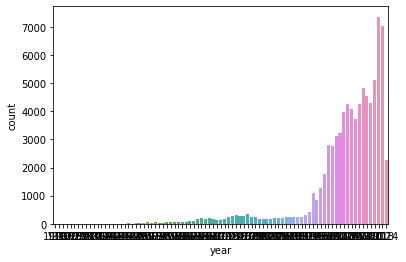

In [10]:
sns.countplot(x="year", data=df)

In [11]:
year_counts = df.groupby(df['year']).size().reset_index(name='counts')

In [12]:
year_counts[year_counts['counts']>=1000]

,year,counts
67,1995,1078
69,1997,1255
70,1998,1767
71,1999,2805
72,2000,2772
73,2001,3122
74,2002,3235
75,2003,3962
76,2004,4257
77,2005,4083


In [13]:
df = df[df['year']>=1995]

In [14]:
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == True]

<AxesSubplot:xlabel='month', ylabel='count'>

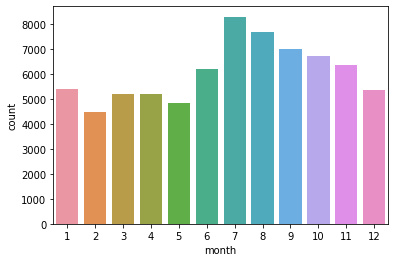

In [15]:
sns.countplot(x="month", data=df)

<AxesSubplot:xlabel='hours'>

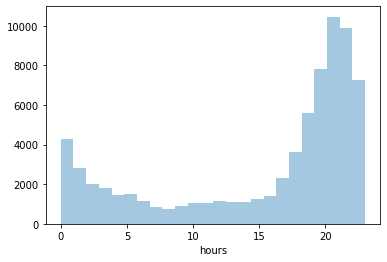

In [16]:
sns.distplot(df['hours'], kde=False, bins=24)

In [18]:
df['longitude '].head()

62    -87.906389
63   -122.269722
64    -93.716944
65    151.588982
66    -79.931111
Name: longitude , dtype: float64

In [19]:
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude '].astype(float)

df['latitude'] = df['latitude'].dropna(axis=0)
df['longitude'] = df['longitude'].dropna(axis=0)


In [20]:
df[df['duration (seconds)'].str.contains("`",na=False)]

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime_dat,day,month,year,time,hours,longitude
27822,2/2/2000 19:33,bouse,az,us,NaN,2`,each a few seconds,Driving through Plomosa Pass towards Bouse Loo...,2/16/2000,33.932500,-114.005000,2000-02-02 19:33:00,2,2,2000,19:33:00,19,-114.005000
35692,4/10/2005 22:52,santa cruz,ca,us,NaN,8`,eight seconds,2 red lights moving together and apart with a ...,4/16/2005,36.974167,-122.029722,2005-04-10 22:52:00,10,4,2005,22:52:00,22,-122.029722
58591,7/21/2006 13:00,ibague (colombia),NaN,NaN,circle,0.5`,1/2 segundo,Viajaba a 27.000 pies en un avion comercial ve...,10/30/2006,4.440663,-75.244141,2006-07-21 13:00:00,21,7,2006,13:00:00,13,-75.244141


In [23]:
df.loc[27822,'duration (seconds)'] = 2
df.loc[35692,'duration (seconds)'] = 8
df.loc[58591,'duration (seconds)'] = 0.5

In [24]:
df['duration(seconds)_num']=df['duration (seconds)'].astype('float64')

In [25]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,datetime,0,0.000000,0,0.000000,62543,object
1,city,0,0.000000,0,0.000000,17990,object
2,state,5184,0.071439,0,0.000000,67,object
3,country,8446,0.116392,0,0.000000,5,object
4,shape,1783,0.024571,0,0.000000,29,object
5,duration (seconds),0,0.000000,0,0.000000,515,object
6,duration (hours/min),0,0.000000,0,0.000000,7626,object
7,comments,12,0.000165,0,0.000000,72258,object
8,date posted,0,0.000000,0,0.000000,317,object
9,latitude,0,0.000000,0,0.000000,17029,float64


In [28]:
coordinates = list(zip(df['latitude'], df['longitude']))

In [33]:
results = rg.search(coordinates)

Loading formatted geocoded file...


In [34]:
results

[{'lat': '43.0389',
  'lon': '-87.90647',
  'name': 'Milwaukee',
  'admin1': 'Wisconsin',
  'admin2': 'Milwaukee County',
  'cc': 'US'},
 {'lat': '37.80437',
  'lon': '-122.2708',
  'name': 'Oakland',
  'admin1': 'California',
  'admin2': 'Alameda County',
  'cc': 'US'},
 {'lat': '39.07251',
  'lon': '-93.71716',
  'name': 'Higginsville',
  'admin1': 'Missouri',
  'admin2': 'Lafayette County',
  'cc': 'US'},
 {'lat': '-33.06052',
  'lon': '151.58408',
  'name': 'Arcadia vale',
  'admin1': 'New South Wales',
  'admin2': 'Lake Macquarie Shire',
  'cc': 'AU'},
 {'lat': '32.77657',
  'lon': '-79.93092',
  'name': 'Charleston',
  'admin1': 'South Carolina',
  'admin2': 'Charleston County',
  'cc': 'US'},
 {'lat': '39.44034',
  'lon': '-84.36216',
  'name': 'Monroe',
  'admin1': 'Ohio',
  'admin2': 'Butler County',
  'cc': 'US'},
 {'lat': '39.64116',
  'lon': '-85.14107',
  'name': 'Connersville',
  'admin1': 'Indiana',
  'admin2': 'Fayette County',
  'cc': 'US'},
 {'lat': '33.42227',
  'lon

In [35]:
results_df = pd.DataFrame(results)

In [36]:
df['country_c']=results_df['cc']
df['city_c']=results_df['name']
df['state_c'] = results_df['admin1']

In [37]:
(df[['country','country_c','state','state_c','city','city_c']])

,country,country_c,state,state_c,city,city_c
62,us,US,wi,New Mexico,milwaukee,Albuquerque
63,us,GB,ca,England,oakland,Harthill
64,us,US,mo,Wisconsin,higginsville,Merrill
65,NaN,US,NaN,New Jersey,lake macquarie (nsw&#44 australia),Mahwah
66,us,US,sc,New Jersey,charleston,Lakehurst
...,...,...,...,...,...,...
80327,us,NaN,tn,NaN,nashville,NaN
80328,us,NaN,id,NaN,boise,NaN
80329,us,NaN,ca,NaN,napa,NaN
80330,us,NaN,va,NaN,vienna,NaN


In [39]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,datetime,0,0.000000,0,0.000000,62543,object
1,city,0,0.000000,0,0.000000,17990,object
2,state,5184,0.071439,0,0.000000,67,object
3,country,8446,0.116392,0,0.000000,5,object
4,shape,1783,0.024571,0,0.000000,29,object
5,duration (seconds),0,0.000000,0,0.000000,515,object
6,duration (hours/min),0,0.000000,0,0.000000,7626,object
7,comments,12,0.000165,0,0.000000,72258,object
8,date posted,0,0.000000,0,0.000000,317,object
9,latitude,0,0.000000,0,0.000000,17029,float64
